<a href="https://colab.research.google.com/github/maxskoda/NR-models/blob/main/Bilayer_On_Gold_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Installs

import sys

libs = ['refnx', 'gspread', 'orsopy', 'ipywidgets', 'requests', 'periodictable']

for lib in libs:
  if lib not in sys.modules:
    !pip install {lib}
  else:
    print(f'importing {lib}')
    __import__(lib)

# !pip install refnx
# !pip install gspread
# !pip install orsopy
# !pip install ipywidgets
# !pip install requests==2.31.0
# !pip install periodictable

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.7 MB/s eta 0:00:00
importing requests
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for periodictable: filename=periodictable-1.7.1-py3-none-any.whl size=752513 sha256=f99ebe6ac66d8616119d535d7d068c00c5fa0277a7365ef32dd662fb1fcfb724
  Stored in directory: /root/.cache/pip/wheels/55/2b/21/c35cc7b4e26fffa3ec4f32a74bd09ce6ce04ba7535dd0b92f2
Successfully built periodictable


In [ ]:
# @title Imports

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

from google.colab import files

gc = gspread.authorize(creds)

from IPython.display import Javascript

import pandas as pd
import re
import re
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import requests
import json

from periodictable import elements

from refnx.reflect import SLD, Slab, ReflectModel, MixedReflectModel, FunctionalForm, Structure, sld_profile, Stack
from refnx.analysis import Objective, GlobalObjective, Parameter, CurveFitter, Transform, process_chain

from refnx.dataset import ReflectDataset

from google.colab import sheets

In [ ]:
# @title Helper functions

# Function to create parameters from the table
def create_parameter(name, value, lower, upper, vary, dist_type='uniform', param1=0, param2=0):
    if dist_type == 'uniform':
        return Parameter(value, name=name, bounds=(lower, upper), vary=vary)
    elif dist_type == 'gaussian':
        return Parameter(value, name=name, bounds=stats.norm(param1, param2), vary=vary)

# Function to convert Google sheet to csv format
def convert_gglsht_url(url):
    pattern = r'https://docs\.google\.com/spreadsheets/d/([a-zA-Z0-9-_]+)(/edit#gid=(\d+)|/edit.*)?'
    replacement = lambda m: f'https://docs.google.com/spreadsheets/d/{m.group(1)}/export?' + (f'gid={m.group(3)}&' if m.group(3) else '') + 'format=csv'
    new_url = re.sub(pattern, replacement, url)
    return new_url

def pretty_plot(model, data):
  # Define the Q range for the reflectivity calculation
  q = np.linspace(0.005, 0.33, 300)  # Q values from 0.005 to 0.3 Å^-1
  # Calculate the reflectivity
  reflectivity = model(q)
  # Plot the calculated reflectivity
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
  # plt.figure(figsize=(4, 3))
  ax1.plot(q, reflectivity, label='Calculated Reflectivity')
  ax1.errorbar(data.x , data.y, data.y_err, label='Measured Reflectivity')
  # ax1.xlabel('Q (Å$^{-1}$)')
  ax1.set_xlabel('Q')
  ax1.set_ylabel('Reflectivity')
  ax1.set_yscale('log')
  ax1.set_xscale('log')
  ax1.legend()
  ax1.grid(True)

  # plot the SLD profilea
  # ax2.plot(*s2.sld_profile(align=-1),label='structure 2')
  ax2.plot(*s1.sld_profile(align=-1),label='structure 1')
  ax2.set_ylabel('SLD /$10^{-6} \AA^{-2}$')
  ax2.set_xlabel('distance / $\AA$')
  ax2.legend()
  fig.show()

In [ ]:
# @title Bilayer
# with open("lipids.json", "r") as f:
#     lipids=json.loads(f.read())

def get_lipids():
  url = "https://raw.githubusercontent.com/refnx/refnx/main/refnx/reflect/_app/lipids.json"  # Raw URL for the JSON file
  response = requests.get(url)
  response.raise_for_status()  # Raise an exception for bad status codes

  return json.loads(response.text)

def scattering_length(compound):
    import periodictable
    sum_formula = periodictable.formula(str(compound)).atoms
    sum_b=0
    for el in sum_formula:
        sum_b += elements.symbol(str(el)).neutron.b_c / 1e5 * sum_formula[el]
    print('sum_b = ', sum_b)
    return sum_b


def leaflet(name='h-DPPC', APM=60, HG_bound_waters=None,
            roughness=5, hydration=0, contrast_SLD=6.35):

    # Water constants

    H2O_SL = -1.64e-5
    D2O_SL = 2e-4
    Water_Volume = 30.4

    ############### HeadGroup ######################
    # Get lipid data from database
    lipids = get_lipids()

    lipid = next((item for item in lipids if item["name"].upper() == str(name).upper()), None) # inner lipid

    HG_SL = scattering_length(str(lipid['head_formula']))
    HG_volume = lipid['conditions'][next(iter(lipid['conditions']))][0]

    tail_SL = scattering_length(str(lipid['tail_formula']))
    tail_volume = lipid['conditions'][next(iter(lipid['conditions']))][1]

    # Relate HG bound waters to SL and volume
    HG_water_SL = HG_bound_waters* (Water_Volume * contrast_SLD)
    HG_water_volume = HG_bound_waters * Water_Volume

    # Add that to the HG Volumes and SLs
    HG_volume = HG_volume + HG_water_volume
    HG_SL=  HG_SL + HG_water_SL

    # Calculate the SLD of the HG
    HG_SLD = HG_SL / HG_volume # SLD = sum b / v

    # Calculate the thickness from the HG volume over the lipid Area per molecule
    HG_thickness= HG_volume / APM # Thcikness = v/APM

    # Calculate the SLD of the tails
    tails_SLD = tail_SL / tail_volume

    # Calculate the thickness of the tails
    tails_thickness = tail_volume / APM

    # Now construct layers adding in a single roughness parmeter and a parameter for defects (hydration)

    head_l = Slab(thick=HG_thickness, sld=HG_SLD, rough=roughness, vfsolv=hydration)
    tail_l = Slab(thick=tails_thickness, sld=tails_SLD, rough=roughness, vfsolv=hydration)
    ###################################################################

    return head_l, tail_l


def bilayer(inner, outer=None, APM_inner=60, APM_outer=None, HG_bound_waters_inner=None, HG_bound_waters_outer=None,
            bilayer_roughness=5, bilayer_hydration=0, contrast_SLD=6.35):
    if outer == None:
        outer = inner
        APM_outer = APM_inner
        HG_bound_waters_outer = HG_bound_waters_inner

    # Water constants

    H2O_SL = -1.64e-5
    D2O_SL = 2e-4
    Water_Volume = 30.4

    ############### inner HeadGroup ######################
    # Get lipid data from database
    lipids = get_lipids()

    lipid = next((item for item in lipids if item["name"].upper() == str(inner).upper()), None) # inner lipid

    HG_SL_inner = scattering_length(str(lipid['head_formula']))
    HG_volume_inner = lipid['conditions'][next(iter(lipid['conditions']))][0]

    tail_SL_inner = scattering_length(str(lipid['tail_formula']))
    tail_volume_inner = lipid['conditions'][next(iter(lipid['conditions']))][1]

    # Relate HG bound waters to SL and volume
    HG_water_SL_inner = HG_bound_waters_inner * (Water_Volume * contrast_SLD)
    HG_water_volume_inner = HG_bound_waters_inner * Water_Volume

    # Add that to the HG Volumes and SLs
    HG_volume_inner = HG_volume_inner + HG_water_volume_inner
    HG_SL_inner =  HG_SL_inner + HG_water_SL_inner

    # Calculate the SLD of the HG
    HG_SLD_inner = HG_SL_inner/HG_volume_inner # SLD = sum b / v

    # Calculate the thickness from the HG volume over the lipid Area per molecule
    HG_thickness_inner = HG_volume_inner / APM_inner # Thcikness = v/APM

    # Calculate the SLD of the tails
    tails_SLD_inner = tail_SL_inner / tail_volume_inner

    # Calculate the thickness of the tails
    tails_thickness_inner = tail_volume_inner / APM_inner

    # Now construct your layers adding in a single roughness parmeter and a parameter for defects (hydration)

    HG_inner_l = Slab(thick=HG_thickness_inner, sld=HG_SLD_inner,
                      rough=bilayer_roughness, vfsolv=bilayer_hydration, name='inner heads')
    tails_inner_l = Slab(thick=tails_thickness_inner, sld=tails_SLD_inner,
                         rough=bilayer_roughness, vfsolv=bilayer_hydration, name='inner tails')
    ###################################################################

    ############### outer HeadGroup ######################
    # Get lipid data from database
    lipids = get_lipids()

    lipid = next((item for item in lipids if item["name"].upper() == str(outer).upper()), None) # outer lipid

    HG_SL_outer = scattering_length(str(lipid['head_formula']))
    HG_volume_outer = lipid['conditions'][next(iter(lipid['conditions']))][0]

    tail_SL_outer = scattering_length(str(lipid['tail_formula']))
    tail_volume_outer = lipid['conditions'][next(iter(lipid['conditions']))][1]

    # Relate HG bound waters to SL and volume
    HG_water_SL_outer = HG_bound_waters_outer * (Water_Volume * contrast_SLD)
    HG_water_volume_outer = HG_bound_waters_outer * Water_Volume

    # Add that to the HG Volumes and SLs
    HG_volume_outer = HG_volume_outer + HG_water_volume_outer
    HG_SL_outer =  HG_SL_outer + HG_water_SL_outer

    # Calculate the SLD of the HG
    HG_SLD_outer = HG_SL_outer/HG_volume_outer # SLD = sum b / v

    # Calculate the thickness from the HG volume over the lipid Area per molecule
    HG_thickness_outer = HG_volume_outer / APM_outer # Thcikness = v/APM

    # Calculate the SLD of the tails
    tails_SLD_outer = tail_SL_outer / tail_volume_outer

    # Calculate the thickness of the tails
    tails_thickness_outer = tail_volume_outer / APM_outer

    # Now construct your layers adding in a single roughness parmeter and a parameter for defects (hydration)

    HG_outer_l = Slab(thick=HG_thickness_outer, sld=HG_SLD_outer,
                      rough=bilayer_roughness, vfsolv=bilayer_hydration, name='outer_heads')
    tails_outer_l = Slab(thick=tails_thickness_outer, sld=tails_SLD_outer,
                         rough=bilayer_roughness, vfsolv=bilayer_hydration, name='outer tails')
    ###################################################################

    return HG_inner_l, tails_inner_l, HG_outer_l, tails_outer_l


In [ ]:
# @title Data entry sheets

# Create a new interactive sheet and add data to it.
# sheet = sheets.InteractiveSheet()

# Open existing sheet
sheet = gc.open('RefNX Parameter Table')

In [ ]:
# @title Refresh spreadsheet and re-generate parameters
# url = 'https://docs.google.com/spreadsheets/d/1aGrL-jpTJ-cuIqSGuJtwt4svpAMQA2-I3nzZrknrnvo/edit?gid=0#gid=0'
# new_url = convert_gglsht_url(url)
# print(new_url)

def refresh_spreadsheet():
  # Open the Google Sheet using its key
  sheet = gc.open_by_key('1aGrL-jpTJ-cuIqSGuJtwt4svpAMQA2-I3nzZrknrnvo')

  # Get the first worksheet
  worksheet = sheet.get_worksheet(0)
  worksheet_bulk_ins = sheet.worksheet('Bulk ins')
  worksheet_bulk_outs = sheet.worksheet('Bulk outs')
  worksheet_scales = sheet.worksheet('Scales')
  worksheet_backgrounds = sheet.worksheet('Backgrounds')

  # Convert the worksheet to a Pandas DataFrame
  df = pd.DataFrame(worksheet.get_all_records())
  df_bulk_ins = pd.DataFrame(worksheet_bulk_ins.get_all_records())
  df_bulk_outs = pd.DataFrame(worksheet_bulk_outs.get_all_records())
  df_scales = pd.DataFrame(worksheet_scales.get_all_records())
  df_backgrounds = pd.DataFrame(worksheet_backgrounds.get_all_records())

  parameters = {}
  # Regular parameters
  for index, row in df.iterrows():
      parameters[row['Name']] = create_parameter(
          name=row['Name'],
          value=row['Initial Value'],
          lower=row['Lower Bound'],
          upper=row['Upper Bound'],
          vary=row['Vary'] == 'TRUE',
          dist_type=row['Type'],
          param1=row['Type Param 1'],
          param2=row['Type Param 2']
      )
  # Bulk parameters:
  for index, row in df_bulk_ins.iterrows():
    parameters[row['Name']] = create_parameter(
        name=row['Name'],
          value=row['Initial Value'],
          lower=row['Lower Bound'],
          upper=row['Upper Bound'],
          vary=row['Vary'] == 'TRUE'
      )
  for index, row in df_bulk_outs.iterrows():
    parameters[row['Name']] = create_parameter(
        name=row['Name'],
          value=row['Initial Value'],
          lower=row['Lower Bound'],
          upper=row['Upper Bound'],
          vary=row['Vary'] == 'TRUE'
      )

  for index, row in df_scales.iterrows():
    parameters[row['Name']] = create_parameter(
        name=row['Name'],
          value=row['Initial Value'],
          lower=row['Lower Bound'],
          upper=row['Upper Bound'],
          vary=row['Vary'] == 'TRUE'
      )
  for index, row in df_backgrounds.iterrows():
    parameters[row['Name']] = create_parameter(
        name=row['Name'],
          value=row['Initial Value'],
          lower=row['Lower Bound'],
          upper=row['Upper Bound'],
          vary=row['Vary'] == 'TRUE'
      )

  return parameters

parameters = refresh_spreadsheet()

================= Contrast 1 =================
       Index          Layer    Scale    Background
0    bulk in             Si  Scale 1  Background 1
1                     oxide                       
2                        Cr                       
3                        Au                       
4                 SAM tails                       
5             Central water                       
6             Bilayer heads                       
7             Bilayer tails                       
8             Bilayer tails                       
9             Bilayer heads                       
10  bulk out            D2O                       
================= Contrast 2 =================
       Index          Layer    Scale    Background
0    bulk in             Si  Scale 1  Background 1
1                     oxide                       
2                        Cr                       
3                        Au                       
4                 SAM tails            

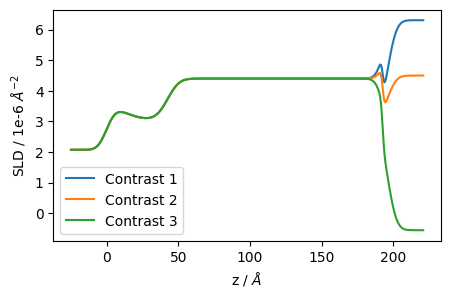

In [ ]:
from math import e
# @title Generate and plot models
Plot = "Yes" # @param ["Yes","No"]

# execute function above to re-genearate parameters from spreadsheet
parameters = refresh_spreadsheet()

# Open the 'Layers' worksheet
worksheet_layers = sheet.worksheet('Layers')
worksheet_bulk_ins = sheet.worksheet('Bulk ins')
worksheet_bulk_outs = sheet.worksheet('Bulk outs')
worksheet_scales = sheet.worksheet('Scales')
worksheet_backgrounds = sheet.worksheet('Backgrounds')

# contrast_1 = sheet.worksheet('Contrast 1')
# contrast_2 = sheet.worksheet('Contrast 2')

# Convert the worksheet to a Pandas DataFrame
df_layers = pd.DataFrame(worksheet_layers.get_all_records())
# df_contrast_1 = pd.DataFrame(contrast_1.get_all_records())
# df_contrast_2 = pd.DataFrame(contrast_2.get_all_records())

# Create a dict to store the layers
layers = {}

# Iterate through the rows in the DataFrame
for index, row in df_layers.iterrows():
  # Get the layer name, thickness, SLD, and roughness parameters
  thickness_param_name = row['Thickness']
  sld_param_name = row['SLD']
  roughness_param_name = row['Roughness']
  hydration = row['Hydration']

  # Create the Slab object using the parameters from the table
  layer = Slab(
      name=row['Layer Name'],
      thick=parameters[thickness_param_name],
      sld=parameters[sld_param_name],
      rough=parameters[roughness_param_name] if roughness_param_name in parameters else Parameter(5), # Default roughness to 5 if not specified
      vfsolv=parameters[hydration]/100 if hydration in parameters else Parameter(0) # Default to no hydration if not specified
  )

  # Add the layer to the dict
  layers[row['Layer Name']] = layer

#################################
# Assemble layers for Contrast 1:
# Get all worksheets in the spreadsheet.
worksheets = sheet.worksheets()

# Create figure for SLD plotting:
if Plot == "Yes":
  fig1, ax = plt.subplots(figsize=(5, 3))

# Iterate over the worksheets and process those named 'Contrast xxx'.
structures = {}
models = {}
for worksheet in worksheets:
  if worksheet.title.startswith('Contrast'):
    # Access and process the data in the worksheet.
    df_contrast = pd.DataFrame(worksheet.get_all_records())

    # Example: Print the title and data of the worksheet.
    # print(f'Worksheet Title: {worksheet.title}')

    scale_name = worksheet.acell('C2').value
    background_name = worksheet.acell('D2').value
    bulk_in_name = worksheet.acell('B2').value

    # Create the bulk media
    bulk_in = SLD(value=parameters[bulk_in_name], name='bulk in')
    bulk_out = SLD(value=parameters[df_contrast['Layer'].iloc[-1]], name='bulk out') # last entry
    scale = parameters[scale_name]
    background = parameters[background_name]

    # Create the structure using the list of layers

    structure = bulk_in(0,0)

    for index, row in df_contrast.iterrows():
      layer_name = row['Layer']

      try:
        layer = layers[layer_name]
        structure = structure | layer
      except KeyError:
        pass # empty rows

    # Add the last layer
    structure = structure | bulk_out(0, 5) #parameters['Bilayer rough'])
    structure.name = worksheet.title
    structures[worksheet.title] = structure

    # Add structure to model
    models['model '+worksheet.title] = ReflectModel(structure, scale=scale, bkg=background)

    # # Upload data and create objective
    # uploaded_files = files.upload()
    # for file_name in uploaded_files:
    #   dataset = ReflectDataset(file_name)
    #   objective = Objective(models['model '+worksheet.title], dataset, name='objective '+worksheet.title)

    # print the layer structure
    print(f"================= {worksheet.title} =================")
    print(df_contrast)
    print("==================")

    # Plot the structure
    if Plot == "Yes":
      structure.plot(fig=fig1);

if Plot == "Yes":
  # Change colour for each contrast
  prop_cycle = plt.rcParams['axes.prop_cycle']
  colors = prop_cycle.by_key()['color']

  lines = ax.get_lines()
  for i, line in enumerate(lines):
    line.set_color(colors[i])
  ax.legend(structures.keys())#, loc='upper left')

print('\n\n\The following models have been created:\n')
for key in models:
  print(key)


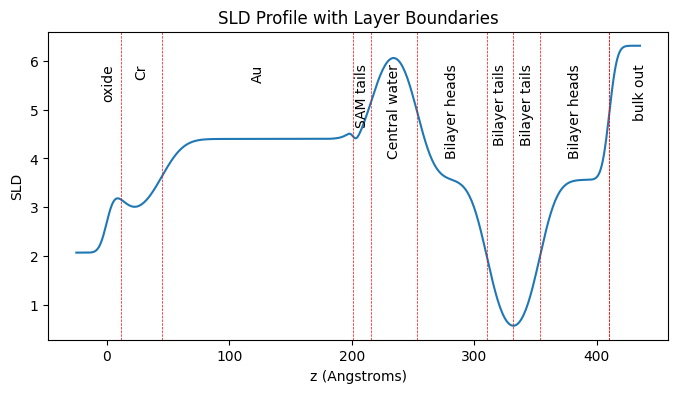

In [ ]:
# @title Plot SLD profile with layer labels
# Assuming 'model' is your ReflectModel object and 'objective' is your Objective object
structure = global_objective.objectives[0].model.structure  # Access the structure from the objective
z, sld = structure.sld_profile()  # Get the z and SLD profiles

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(z, sld)  # Plot the SLD profile

# Calculate layer boundaries and get layer names
boundaries = [0]  # Initialize with the first boundary at z=0
centres = [0]  # layer midpoints
layer_names = [structure.components[0].name]  # Start with ambient layer name

for component in structure.components[1:]:  # Skip the first component (ambient)
    boundaries.append(boundaries[-1] + component.thick.value)
    centres.append(boundaries[-1] - component.thick.value/2)
    layer_names.append(component.name)

centres[1] = centres[1] - 5 # move first layer further left
centres[-1] = centres[-1] + 25 # move bulk out further right

# Add vertical lines and labels for layer boundaries
for boundary, centre, layer_name in zip(boundaries[1:], centres[1:], layer_names[1:]):  # Skip ambient for labels
    ax.axvline(x=boundary, color='r', linestyle='--', linewidth=0.5)
    ax.text(centre, ax.get_ylim()[1] * 0.9, layer_name,
            rotation=90, ha='center', va='top', fontsize=10)  # Adjust position as needed

ax.set_xlabel('z (Angstroms)')
ax.set_ylabel('SLD')
ax.set_title('SLD Profile with Layer Boundaries')
plt.show()

In [ ]:
# @title Load files
import ipywidgets as widgets
from IPython.display import display
import os

# Get the number of contrasts
worksheets = sheet.worksheets()
contrast_count = sum(1 for worksheet in worksheets if worksheet.title.startswith('Contrast'))

# Create file selection dropdowns for each contrast
file_dropdowns = {}
for i in range(1, contrast_count + 1):
  file_dropdown = widgets.Dropdown(
      options=[],
      description=f'Contrast {i}:',
      disabled=False,
  )
  file_dropdowns[f'Contrast {i}'] = file_dropdown

# Create a container for the widgets
form_items = list(file_dropdowns.values())

# Create the form
form = widgets.VBox(form_items)

# Display the form
display(form)

# Function to refresh dropdowns with files from /content
def refresh_dropdowns():
  files_in_content = [f for f in os.listdir('/content') if os.path.isfile(os.path.join('/content', f))]
  for dropdown in file_dropdowns.values():
    dropdown.options = files_in_content

# Refresh dropdowns initially
refresh_dropdowns()

# Function to handle file selection
def handle_selection(change):
  selected_filename = change.new
  # print(f'Selected file for {change.owner.description}: {selected_filename}')
  # You can process the selected file here

# Assign the selection handler to each file dropdown widget
for dropdown_widget in file_dropdowns.values():
  dropdown_widget.observe(handle_selection, names='value')

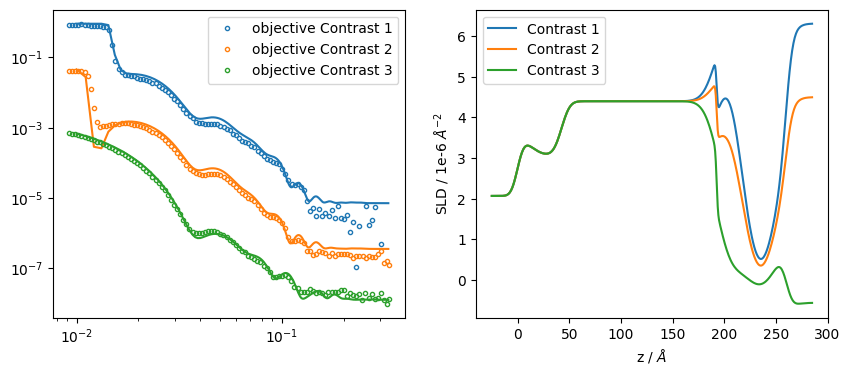

In [ ]:
# @title Plot Objectives and Data
objectives = {}
for contrast_name, dropdown in file_dropdowns.items():
  if dropdown.value:  # Check if a file is selected
    try:
      dataset = ReflectDataset(dropdown.value)
      objective = Objective(models['model ' + contrast_name], dataset, name='objective ' + contrast_name)
      objectives[contrast_name] = objective
    except Exception as e:
      print(f"Error creating objective for {contrast_name}: {e}")
  else:
    print(f"No file selected for {contrast_name}")

# Now you have a dictionary 'objectives' containing the objective for each contrast.

go = []
for obj in objectives.values():
  go.append(obj)

global_objective = GlobalObjective(go)

# Creat figure for data plotting:
# Change colour for each contrast
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig2, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
q = np.linspace(0.01, 0.33, 300)
for col, objective in enumerate(objectives.values()):
  ax1.plot(objective.data.x, objective.data.y * 20**-col, marker='o', linestyle='', color=colors[col],
          markersize=3, mew=1, markerfacecolor='none', label=objective.name)
  ax1.plot(q, objective.model(q) * 20**-col)

  objective.model.structure.plot(fig=fig2)

ax1.legend();
ax1.set_xscale('log')
ax1.set_yscale('log')

lines = ax2.get_lines()
for i, line in enumerate(lines):
  line.set_color(colors[i])
ax2.legend(structures.keys());#, loc='upper left')

In [ ]:
print(global_objective.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'Scale 1'   , value=0.8 +/- 0.00213, bounds=[0.8, 1.1]>
<Parameter:'Background 1' , value=4.33909e-06 +/- 1.38e-07, bounds=[1e-08, 5e-05]>
<Parameter: 'Oxide thick' , value=11.4444 +/- 14.7 , bounds=[8.0, 60.0]>
<Parameter:  'Cr thick'   , value=33.2523 +/- 19.6 , bounds=[10.0, 60.0]>
<Parameter:   'Cr SLD'    , value=2.84821 +/- 1.01 , bounds=[2.236, 4.0]>
<Parameter:  'Cr rough'   , value=9.20489 +/- 41.4 , bounds=[3.0, 15.0]>
<Parameter:  'Au thick'   , value=156.309 +/- 11.4 , bounds=[100.0, 200.0]>
<Parameter:   'Au SLD'    , value=4.4 +/- 0.0108, bounds=[4.4, 4.7]>
<Parameter:  'Au rough'   , value=14.118 +/- 5.77 , bounds=[4.0, 15.0]>
<Parameter:'Sam tails thick', value=14.96 +/- 1.94 , bounds=[1.0, 35.0]>
<Parameter:'Sam tails SLD', value=4.04295 +/- 0.94 , bounds=[-0.4, 6.3]>
<Parameter:  'Sam rough'  , value=2.07213 +/- 5.79 , bounds=[2.0, 15.0]>
<Paramet

In [ ]:
fitter = CurveFitter(global_objective)
fitter.fit('differential_evolution')

-277.70674048234: : 596it [29:32,  2.97s/it]


             message: Optimization terminated successfully.
             success: True
                 fun: -278.6322509881345
                   x: [ 8.000e-01  3.799e-06 ...  7.918e-06 -5.363e-01]
                 nit: 596
                nfev: 188495
          population: [[ 8.000e-01  3.836e-06 ...  7.942e-06 -5.404e-01]
                       [ 8.000e-01  3.892e-06 ...  7.934e-06 -5.371e-01]
                       ...
                       [ 8.001e-01  3.799e-06 ...  8.061e-06 -5.473e-01]
                       [ 8.000e-01  3.737e-06 ...  7.884e-06 -5.512e-01]]
 population_energies: [-2.786e+02 -2.753e+02 ... -2.702e+02 -2.711e+02]
                 jac: [ 1.036e+04  9.159e+03 ...  5.499e+03 -8.736e+00]
               covar: [[ 4.387e-06 -1.218e-12 ...  8.681e-12  1.249e-05]
                       [-1.218e-12  1.353e-14 ...  1.663e-15  7.568e-10]
                       ...
                       [ 8.681e-12  1.663e-15 ...  2.553e-14  1.660e-09]
                       [ 1.249e-05 

In [ ]:
fitter.sample(3000, pool=8)

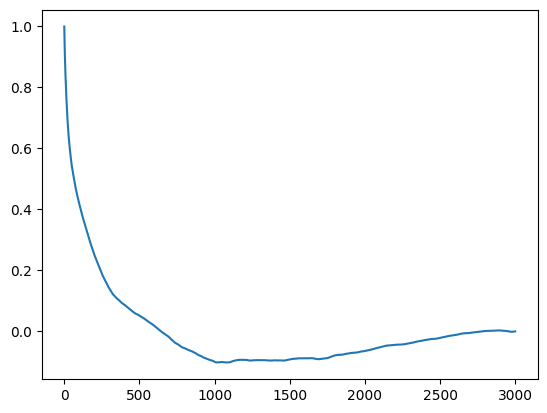

In [ ]:
plt.plot(fitter.acf()[:, 4])
fitter.reset()

In [ ]:
res = fitter.sample(15, nthin=1000, pool=1)

NameError: name 'fitter' is not defined

In [ ]:
# @title Update paramter table

# Get the fitted parameters
fitted_parameters = global_objective.parameters.flattened()

# Open the Google Sheet using its key
sheet = gc.open_by_key('1aGrL-jpTJ-cuIqSGuJtwt4svpAMQA2-I3nzZrknrnvo')

# Get the first worksheet
worksheet = sheet.get_worksheet(0)

# Convert the worksheet data to a Pandas DataFrame
df_worksheet = pd.DataFrame(worksheet.get_all_records())

# Update the 'Initial Value' column in the worksheet with the fitted values
for index, row in df_worksheet.iterrows():
  parameter_name = row['Name']
  for p in fitted_parameters:
    if p.name == parameter_name:
      worksheet.update_cell(index + 2, 2, p.value)  # +2 to account for header row and 1-based indexing

In [ ]:
# !pip install orsopy
# Make sure the orsopy package is installed.

from orsopy.slddb import api
import refnx.analysis as analysis
import refnx.reflect as reflect
import refnx.dataset as dataset

# Step 1: Search for material data in the ORSO SLD database
# Let's say we're looking for Silicon dioxide (SiO2)
results = api.search(name="water")
m=api.material(results[0]['ID']) # retrieve all data for the given material, see Material class.
print(m.rho_n)

6.360408603667383e-06


In [ ]:
import requests
import json

url = "https://raw.githubusercontent.com/refnx/refnx/main/refnx/reflect/_app/lipids.json"  # Raw URL for the JSON file
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad status codes

lipids_data = json.loads(response.text)
print(lipids_data)


[{'name': 'h-DMPC', 'chemical_name': '14:0 PC / 1,2-dimyristoyl-sn-glycero-3-phosphocholine', 'head_formula': 'C10H18O8NP', 'tail_formula': 'C26H54', 'references': ['DMPC in the fluid phase: J.F. Nagle and S. Tristram-Nagle (2000) Biochim. Biophys. Acta: Rev. Biomembr. 1469: 159-195', 'DMPC in the gel phase: S. Tristram-Nagle et al. (2002) Biophys. J. 83: 3324-3335'], 'conditions': {'fluid30C': [319, 782], 'gel10C': [319, 710]}, 'head_exchangable': 0, 'tail_exchangable': 0}, {'name': 'd54-DMPC', 'chemical_name': '14:0 PC-d54 / 1,2-dimyristoyl-d54-sn-glycero-3-phosphocholine', 'head_formula': 'C10H18O8NP', 'tail_formula': 'C26D54', 'references': ['DMPC in the fluid phase: J.F. Nagle and S. Tristram-Nagle (2000) Biochim. Biophys. Acta: Rev. Biomembr. 1469: 159-195', 'DMPC in the gel phase: S. Tristram-Nagle et al. (2002) Biophys. J. 83: 3324-3335'], 'conditions': {'fluid30C': [319, 782], 'gel10C': [319, 710]}, 'head_exchangable': 0, 'tail_exchangable': 0}, {'name': 'h-DMPG', 'chemical_na

In [ ]:
WPLH = Parameter(9, 'WPLH', bounds=[0, 12], vary=True)
heads, tails, _, _ = bilayer(inner='h-DPPC', APM_inner=65, HG_bound_waters_inner=WPLH)
print(heads, tails)

sum_b =  0.0006007779999999999
sum_b =  -0.00032483800000000004
sum_b =  0.0006007779999999999
sum_b =  -0.00032483800000000004
________________________________________________________________________________
Parameters:  'inner heads' 
<Parameter:     None      , value=9.11692  (fixed) , bounds=None>
________________________________________________________________________________
Parameters:       ''       
<Parameter:     None      , value=2.93176  (fixed) , bounds=None>
<Parameter:   ' - isld'   , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'inner heads - rough', value=5  (fixed) , bounds=[-inf, inf]>
<Parameter:'inner heads - volfrac solvent', value=0  (fixed) , bounds=[0.0, 1.0]> ________________________________________________________________________________
Parameters:  'inner tails' 
<Parameter:'inner tails - thick', value=12.6923  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:       ''       
<Pa